In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc

In [53]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=20)
plt.rc('axes', titlesize=20) 

In [57]:
ms=m.sample(n=10000)

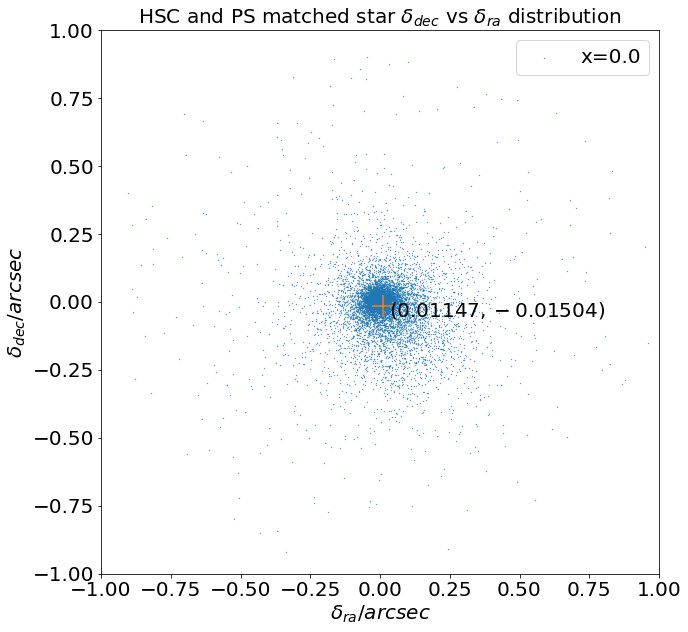

In [58]:
delta_ra=(ms.ra_2.values-ms.ra_1.values)*3600
delta_dec=(ms.dec_2.values-ms.dec_1.values)*3600
plt.figure(figsize=(10,10))
plt.title(r'HSC and PS matched star $\delta_{dec}$ vs $\delta_{ra}$ distribution')
plt.scatter(delta_ra,delta_dec,alpha=1,s=0.1,label='x=%.1f'%(np.mean(delta_ra)))
plt.scatter(np.mean(delta_ra),np.mean(delta_dec),s=500,marker='+')
plt.text(np.mean(delta_ra)+0.02,np.mean(delta_dec)-0.04,'$(%0.5f,%0.5f)$'%(np.mean(delta_ra),np.mean(delta_dec)))
plt.xlabel(r'$\delta_{ra}/arcsec$')
plt.ylabel(r'$\delta_{dec}/arcsec$')
plt.axis([-1,1,-1,1])
plt.legend()

In [4]:
cd /Users/tianqiu/Downloads/PanStarrs/

/Users/tianqiu/Downloads/PanStarrs


In [5]:
m=pd.read_csv('matchedstar.csv')

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27,29,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
m.columns

Index(['col1', 'id', 'ra_1', 'dec_1', 'parent', 'g_mag', 'r_mag', 'i_mag',
       'z_mag', 'y_mag', 'i_err', 'y_err', 'r_err', 'z_err', 'g_err', 'ra_err',
       'dec_err', 'epoch', 'pm_ra', 'pm_dec', 'pm_ra_err', 'pm_dec_err',
       'footprint', 'ra_2', 'dec_2', 'r_extendedness_value', 'g_cmodel_mag',
       'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'g_psfflux_mag', 'r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag',
       'g_psfflux_magsigma', 'r_psfflux_magsigma', 'i_psfflux_magsigma',
       'z_psfflux_magsigma', 'a_g', 'a_r', 'a_i', 'a_z', 'Separation'],
      dtype='object')

In [31]:
bins=np.arange(16,25,0.25)

(array([5.0000e+00, 1.5000e+01, 6.1000e+01, 1.6000e+02, 4.2900e+02,
        9.6900e+02, 3.9370e+03, 7.7910e+03, 1.1564e+04, 1.3213e+04,
        1.5111e+04, 1.6724e+04, 1.8307e+04, 2.0031e+04, 2.1757e+04,
        2.4087e+04, 2.5916e+04, 2.8178e+04, 3.0216e+04, 3.2566e+04,
        3.4491e+04, 3.6618e+04, 3.8688e+04, 4.1713e+04, 4.4847e+04,
        5.0878e+04, 5.9628e+04, 5.6862e+04, 2.8297e+04, 6.3040e+03,
        1.5300e+03, 4.9100e+02, 1.3300e+02, 8.1000e+01, 3.6000e+01]),
 array([16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75, 18.  ,
        18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75, 20.  , 20.25,
        20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 ,
        22.75, 23.  , 23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 , 24.75]),
 <a list of 1 Patch objects>)

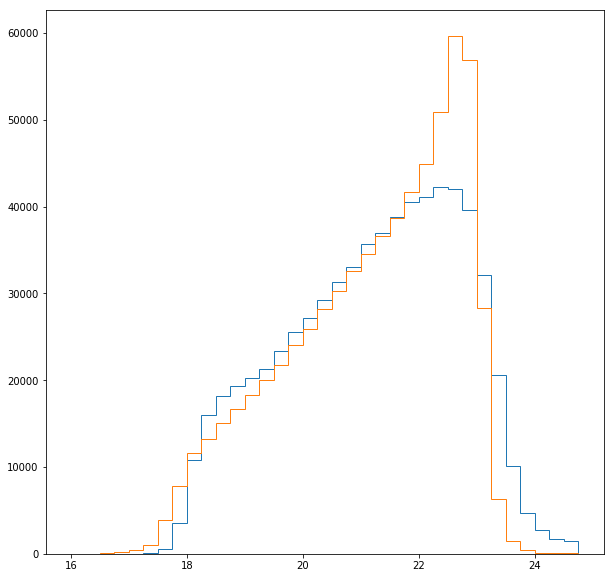

In [34]:
plt.figure(figsize=(10,10))
plt.hist(m.i_psfflux_mag,bins=bins,histtype='step')
plt.hist(m.i_mag,bins=bins,histtype='step')

In [6]:
def calc_cov(mc):
    if mc.shape[0]==2 and mc.shape[1]!=2:
        mc=mc.T
    cov=np.cov(mc.T)
    return cov

In [81]:
q=m.sample(n=50000)

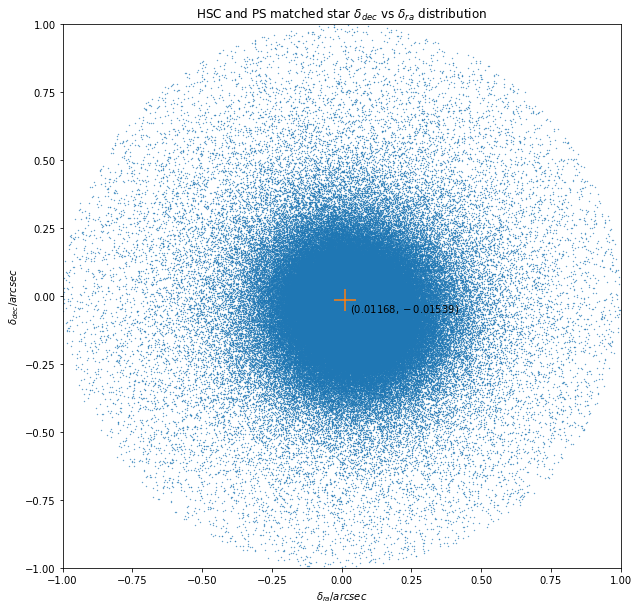

In [82]:
delta_ra=(m.ra_2.values-m.ra_1.values)*3600
delta_dec=(m.dec_2.values-m.dec_1.values)*3600
plt.figure(figsize=(10,10))
plt.title(r'HSC and PS matched star $\delta_{dec}$ vs $\delta_{ra}$ distribution')
plt.scatter(delta_ra,delta_dec,alpha=1,s=0.1)
plt.scatter(np.mean(delta_ra),np.mean(delta_dec),s=500,marker='+')
plt.text(np.mean(delta_ra)+0.02,np.mean(delta_dec)-0.04,'$(%0.5f,%0.5f)$'%(np.mean(delta_ra),np.mean(delta_dec)))
plt.xlabel(r'$\delta_{ra}/arcsec$')
plt.ylabel(r'$\delta_{dec}/arcsec$')
plt.axis([-1,1,-1,1])
plt.savefig('HSC-PS_star_dist_all.png')


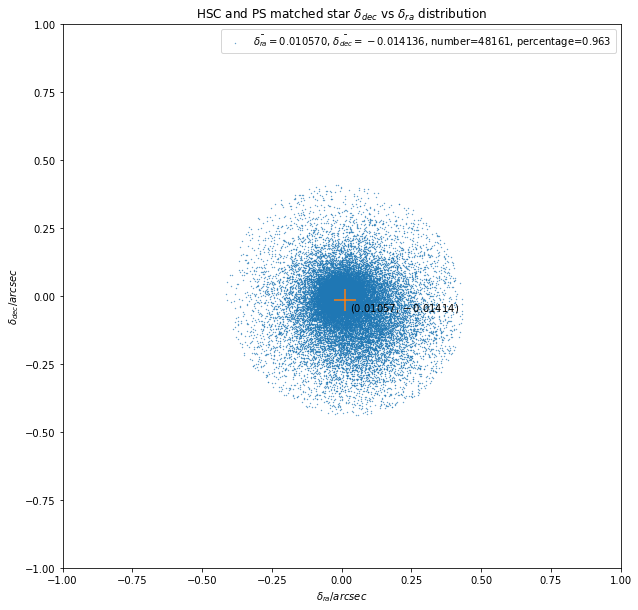

In [83]:
#clip with 3sigma with cov matrix
l=[]
ra=(q.ra_2.values-q.ra_1.values)*3600
dec=(q.dec_2.values-q.dec_1.values)*3600
mx=np.array([ra,dec])
mx=mx.T
for j,x in enumerate(mx):
    cov=calc_cov(mx)
    if (x-mx.mean(0)).dot(np.linalg.inv(cov)).dot(x-mx.mean(0))<11.8:
        l.append(j)
t=q.iloc[l]
ra=(t.ra_2-t.ra_1)*3600
dec=(t.dec_2-t.dec_1)*3600

plt.figure(figsize=(10,10))
plt.title(r'HSC and PS matched star $\delta_{dec}$ vs $\delta_{ra}$ distribution')
plt.scatter(ra,dec,alpha=1,s=0.1,label=r'$\bar{\delta_{ra}}=%f$, $\bar{\delta_{dec}}=%f$, number=%.0f, percentage=%0.3f'%(np.mean(ra),np.mean(dec),len(t),len(t)/len(q)))
plt.scatter(np.mean(ra),np.mean(dec),s=500,marker='+')
plt.text(np.mean(ra)+0.02,np.mean(dec)-0.04,'$(%0.5f,%0.5f)$'%(np.mean(ra),np.mean(dec)))
plt.xlabel(r'$\delta_{ra}/arcsec$')
plt.ylabel(r'$\delta_{dec}/arcsec$')
plt.axis([-1,1,-1,1])
plt.legend()
plt.savefig('HSC-PS_star_dist_sample_3sigma.png')

In [7]:
mm=[[]*i for i in range(6)]
for i in range(6):
    mm[i]=m[(m.i_psfflux_mag>=18+i)&(m.i_psfflux_mag<19+i)]
delta_ra=[[]*i for i in range(6)]
delta_dec=[[]*i for i in range(6)]
mram=[]
mdecm=[]
for i in range(6):
    delta_ra[i]=(mm[i].ra_2.values-mm[i].ra_1.values)*3600
    delta_dec[i]=(mm[i].dec_2.values-mm[i].dec_1.values)*3600
    mram.append(np.mean(delta_ra[i]))
    mdecm.append(np.mean(delta_dec[i]))

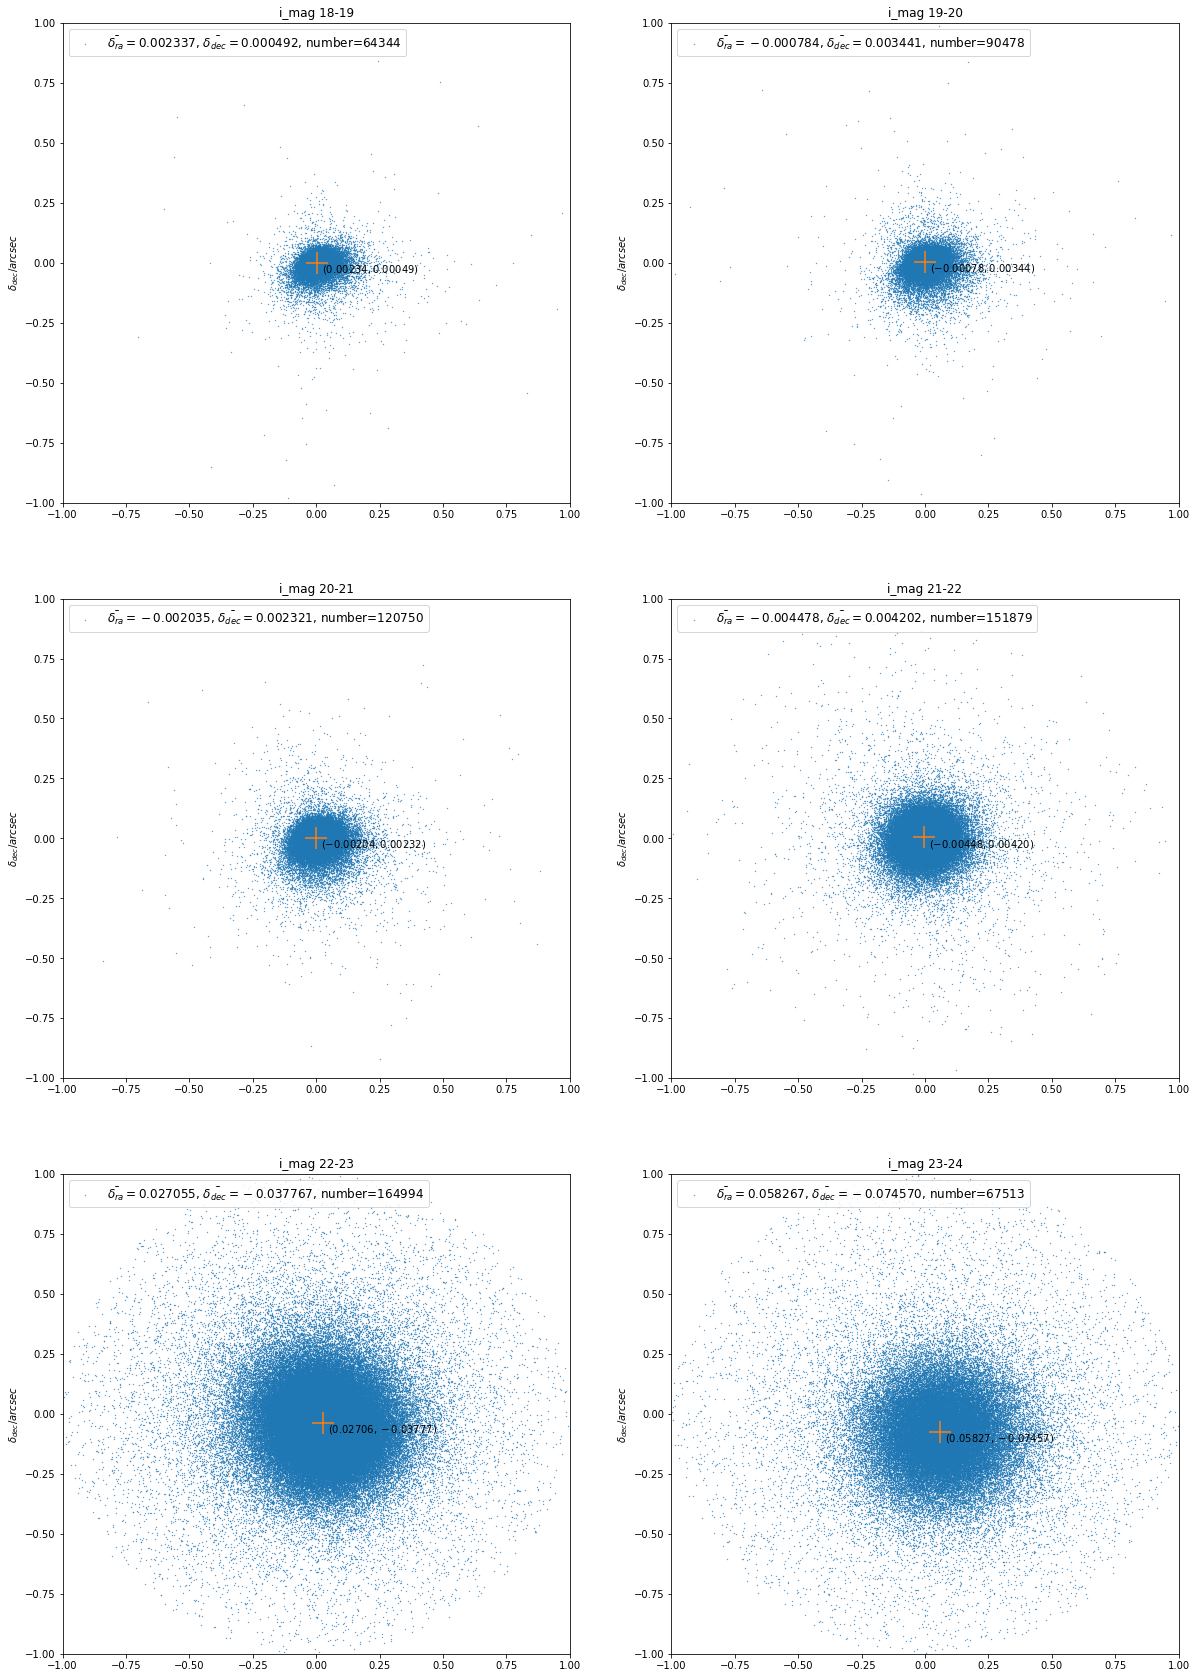

In [8]:
plt.figure(figsize=(20,30))
for i in range(6):
    plt.subplot(321+i)
    plt.title(r'i_mag '+str(18+i)+'-'+str(19+i))
    plt.scatter(delta_ra[i],delta_dec[i],alpha=1,s=0.1,label=r'$\bar{\delta_{ra}}=%f$, $\bar{\delta_{dec}}=%f$, number=%.0f'%(mram[i],mdecm[i],len(mm[i])))
    plt.scatter(mram[i],mdecm[i],s=500,marker='+')
    plt.text(mram[i]+0.02,mdecm[i]-0.04,'$(%0.5f,%0.5f)$'%(mram[i],mdecm[i]))
    plt.ylabel(r'$\delta_{dec}/arcsec$')
    plt.legend(loc=2,fontsize=12)
    plt.axis([-1,1,-1,1])
plt.savefig('HSC-PS_star_mag_dist.png')

Text(0.5, 1.0, '$\\delta_{ra}$ and $\\delta_{dec}$ distribution by different ra')

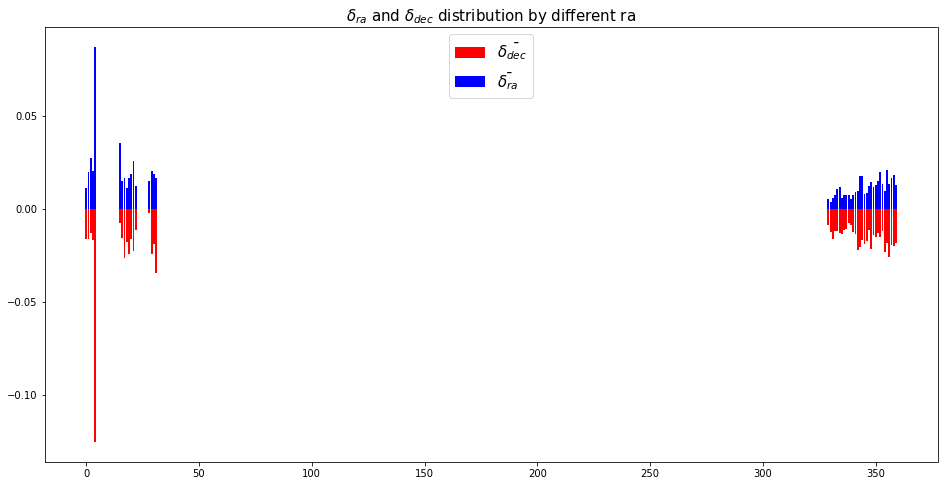

In [40]:
xm=[]
ram=[]
decm=[]
for i in range(360):
    t=m[(m.ra_1>i)&(m.ra_1<=(i+1))]
    if t.empty:
        continue
    xm.append(i)
    mdelta_ra=(t.ra_2.values-t.ra_1.values)*3600
    mdelta_dec=(t.dec_2.values-t.dec_1.values)*3600
    ram.append(np.mean(mdelta_ra))
    decm.append(np.mean(mdelta_dec))
plt.figure(figsize=(16,8))
plt.bar(xm,decm,color='red',label=r'$\bar{\delta_{dec}}$')
plt.bar(xm,ram,color='blue',label=r'$\bar{\delta_{ra}}$')
plt.legend(loc=9,fontsize=15)
plt.title(r'$\delta_{ra}$ and $\delta_{dec}$ distribution by different ra',fontsize=15)

In [11]:
gl=pd.read_csv('matchedgl.csv')

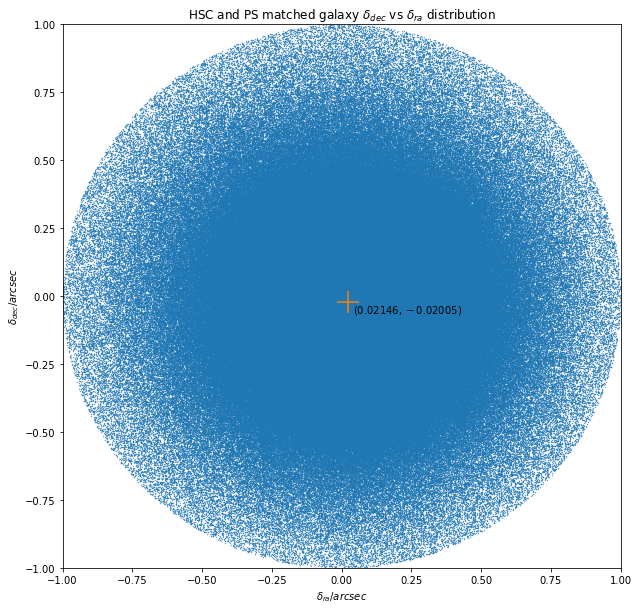

In [78]:
delta_ra=(gl.ra_2.values-gl.ra_1.values)*3600
delta_dec=(gl.dec_2.values-gl.dec_1.values)*3600
plt.figure(figsize=(10,10))
plt.title(r'HSC and PS matched galaxy $\delta_{dec}$ vs $\delta_{ra}$ distribution')
plt.scatter(delta_ra,delta_dec,alpha=1,s=0.1)
plt.scatter(np.mean(delta_ra),np.mean(delta_dec),s=500,marker='+')
plt.text(np.mean(delta_ra)+0.02,np.mean(delta_dec)-0.04,'$(%0.5f,%0.5f)$'%(np.mean(delta_ra),np.mean(delta_dec)))
plt.xlabel(r'$\delta_{ra}/arcsec$')
plt.ylabel(r'$\delta_{dec}/arcsec$')
plt.axis([-1,1,-1,1])
plt.savefig('HSC-PS_galaxy_dist_all.png')



In [20]:
q=gl.sample(n=50000)

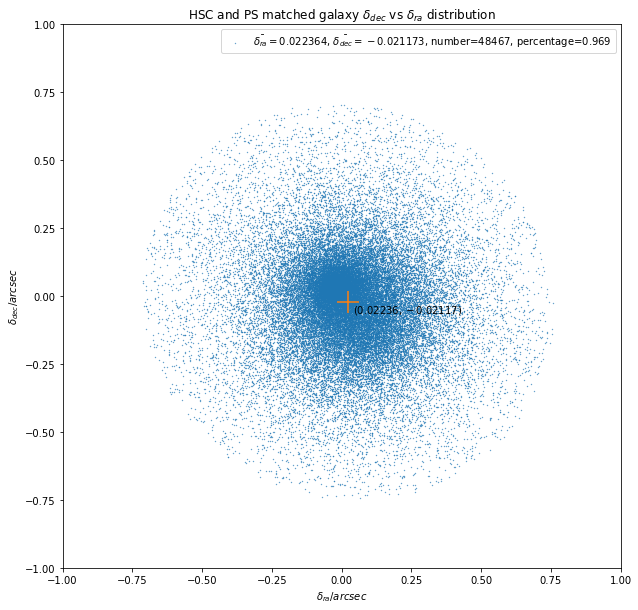

In [80]:
#clip with 3sigma with cov matrix
l=[]
ra=(q.ra_2.values-q.ra_1.values)*3600
dec=(q.dec_2.values-q.dec_1.values)*3600
mx=np.array([ra,dec])
mx=mx.T
for j,x in enumerate(mx):
    cov=calc_cov(mx)
    if (x-mx.mean(0)).dot(np.linalg.inv(cov)).dot(x-mx.mean(0))<11.8:
        l.append(j)
t=q.iloc[l]
ra=(t.ra_2-t.ra_1)*3600
dec=(t.dec_2-t.dec_1)*3600

plt.figure(figsize=(10,10))
plt.title(r'HSC and PS matched galaxy $\delta_{dec}$ vs $\delta_{ra}$ distribution')
plt.scatter(ra,dec,alpha=1,s=0.1,label=r'$\bar{\delta_{ra}}=%f$, $\bar{\delta_{dec}}=%f$, number=%.0f, percentage=%0.3f'%(np.mean(ra),np.mean(dec),len(t),len(t)/len(q)))
plt.scatter(np.mean(ra),np.mean(dec),s=500,marker='+')
plt.text(np.mean(ra)+0.02,np.mean(dec)-0.04,'$(%0.5f,%0.5f)$'%(np.mean(ra),np.mean(dec)))
plt.xlabel(r'$\delta_{ra}/arcsec$')
plt.ylabel(r'$\delta_{dec}/arcsec$')
plt.axis([-1,1,-1,1])
plt.legend()
plt.savefig('HSC-PS_galaxy_dist_sample_3sigma.png')

In [21]:
mm=[[]*i for i in range(6)]
for i in range(6):
    mm[i]=gl[(gl.i_psfflux_mag>=18+i)&(gl.i_psfflux_mag<19+i)]
delta_ra=[[]*i for i in range(6)]
delta_dec=[[]*i for i in range(6)]
mram=[]
mdecm=[]
for i in range(6):
    delta_ra[i]=(mm[i].ra_2.values-mm[i].ra_1.values)*3600
    delta_dec[i]=(mm[i].dec_2.values-mm[i].dec_1.values)*3600
    mram.append(np.mean(delta_ra[i]))
    mdecm.append(np.mean(delta_dec[i]))

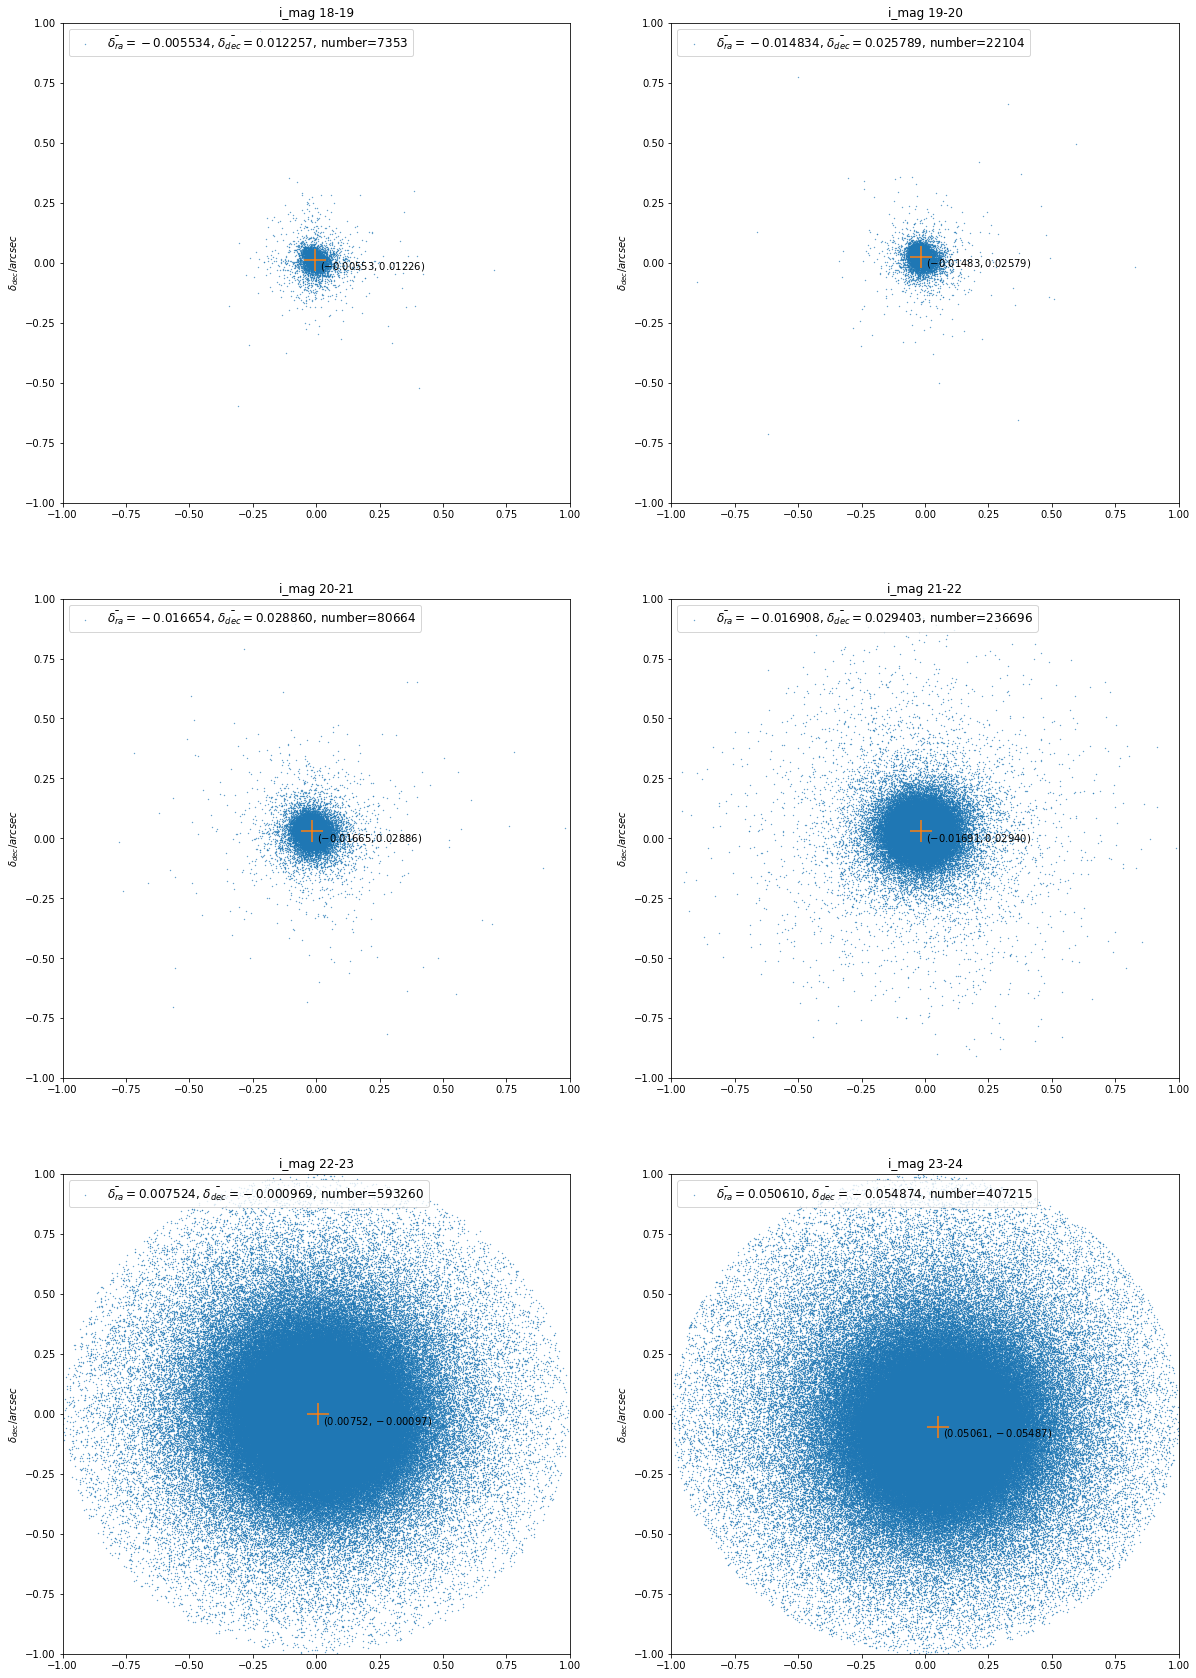

In [22]:
plt.figure(figsize=(20,30))
for i in range(6):
    plt.subplot(321+i)
    plt.title(r'i_mag '+str(18+i)+'-'+str(19+i))
    plt.scatter(delta_ra[i],delta_dec[i],alpha=1,s=0.1,label=r'$\bar{\delta_{ra}}=%f$, $\bar{\delta_{dec}}=%f$, number=%.0f'%(mram[i],mdecm[i],len(mm[i])))
    plt.scatter(mram[i],mdecm[i],s=500,marker='+')
    plt.text(mram[i]+0.02,mdecm[i]-0.04,'$(%0.5f,%0.5f)$'%(mram[i],mdecm[i]))
    plt.ylabel(r'$\delta_{dec}/arcsec$')
    plt.legend(loc=2,fontsize=12)
    plt.axis([-1,1,-1,1])
plt.savefig('HSC-PS_galaxy_mag_dist.png')

In [84]:
sgl=pd.read_csv('matchedspecgl.csv')

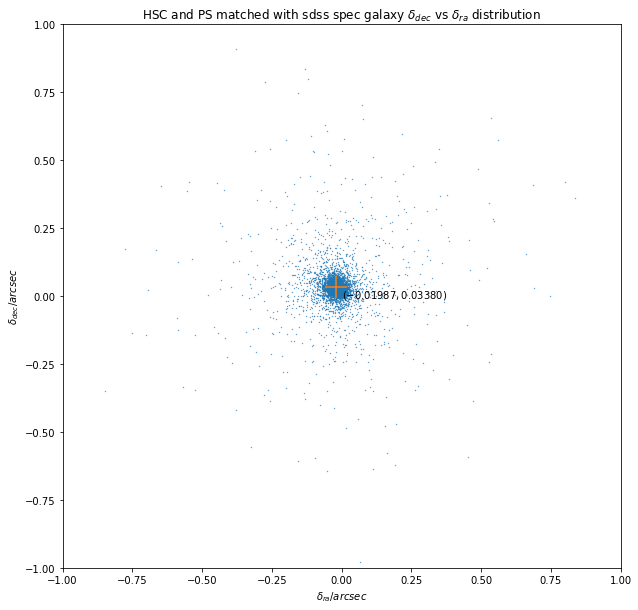

In [90]:
delta_ra=(sgl.ra_2.values-sgl.ra_1.values)*3600
delta_dec=(sgl.dec_2.values-sgl.dec_1.values)*3600
plt.figure(figsize=(10,10))
plt.title(r'HSC and PS matched with sdss spec galaxy $\delta_{dec}$ vs $\delta_{ra}$ distribution')
plt.scatter(delta_ra,delta_dec,alpha=1,s=0.1)
plt.scatter(np.mean(delta_ra),np.mean(delta_dec),s=500,marker='+')
plt.text(np.mean(delta_ra)+0.02,np.mean(delta_dec)-0.04,'$(%0.5f,%0.5f)$'%(np.mean(delta_ra),np.mean(delta_dec)))
plt.xlabel(r'$\delta_{ra}/arcsec$')
plt.ylabel(r'$\delta_{dec}/arcsec$')
plt.axis([-1,1,-1,1])
plt.savefig('HSC-PS_specgalaxy_dist_all.png')




In [87]:
qs=pd.read_csv('matchedquasar.csv')

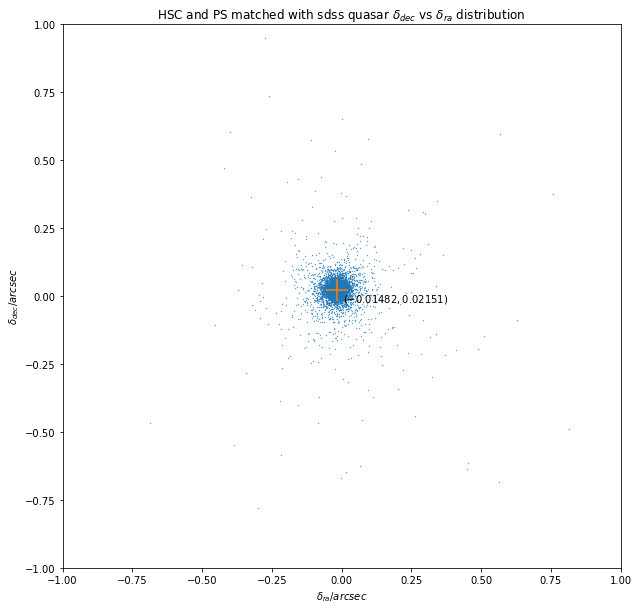

In [89]:
delta_ra=(qs.ra_2.values-qs.ra_1.values)*3600
delta_dec=(qs.dec_2.values-qs.dec_1.values)*3600
plt.figure(figsize=(10,10))
plt.title(r'HSC and PS matched with sdss quasar $\delta_{dec}$ vs $\delta_{ra}$ distribution')
plt.scatter(delta_ra,delta_dec,alpha=1,s=0.1)
plt.scatter(np.mean(delta_ra),np.mean(delta_dec),s=500,marker='+')
plt.text(np.mean(delta_ra)+0.02,np.mean(delta_dec)-0.04,'$(%0.5f,%0.5f)$'%(np.mean(delta_ra),np.mean(delta_dec)))
plt.xlabel(r'$\delta_{ra}/arcsec$')
plt.ylabel(r'$\delta_{dec}/arcsec$')
plt.axis([-1,1,-1,1])
plt.savefig('HSC-PS_quasar_dist_all.png')




In [34]:
m3=pd.read_csv("m_star_HSC_S82_PS.csv")

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
m3.columns

Index(['ra_1', 'dec_1', 'r_extendedness_value', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'g_psfflux_mag', 'r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag',
       'g_psfflux_magsigma', 'r_psfflux_magsigma', 'i_psfflux_magsigma',
       'z_psfflux_magsigma', 'a_g', 'a_r', 'a_i', 'a_z', 'ra_2', 'dec_2',
       'flags', 'g', 'r', 'i', 'z', 'err_g', 'err_r', 'err_i', 'err_z',
       'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'psfmagerr_g',
       'psfmagerr_r', 'psfmagerr_i', 'psfmagerr_z', 'extinction_g',
       'extinction_r', 'extinction_i', 'extinction_z', 'Separation_1', 'col1',
       'id', 'ra', 'dec', 'parent', 'g_mag', 'r_mag', 'i_mag', 'z_mag',
       'y_mag', 'i_err', 'y_err', 'r_err', 'z_err', 'g_err', 'ra_err',
       'dec_err', 'epoch', 'pm_ra', 'pm_dec', 'pm_ra_err', 'pm_dec_err',
       'footprint', 'Separation'],
      dtype='object')

In [86]:
mm=[[]*i for i in range(6)]
for i in range(6):
    mm[i]=m3[(m3.i_psfflux_mag>=18+i)&(m3.i_psfflux_mag<19+i)]
delta_ra=[[]*i for i in range(6)]
delta_dec=[[]*i for i in range(6)]
mram=[]
mdecm=[]
for i in range(6):
    delta_ra[i]=(mm[i].ra_1.values-mm[i].ra.values)*3600000
    delta_dec[i]=(mm[i].dec_1.values-mm[i].dec.values)*3600000
    mram.append(np.mean(delta_ra[i]))
    mdecm.append(np.mean(delta_dec[i]))

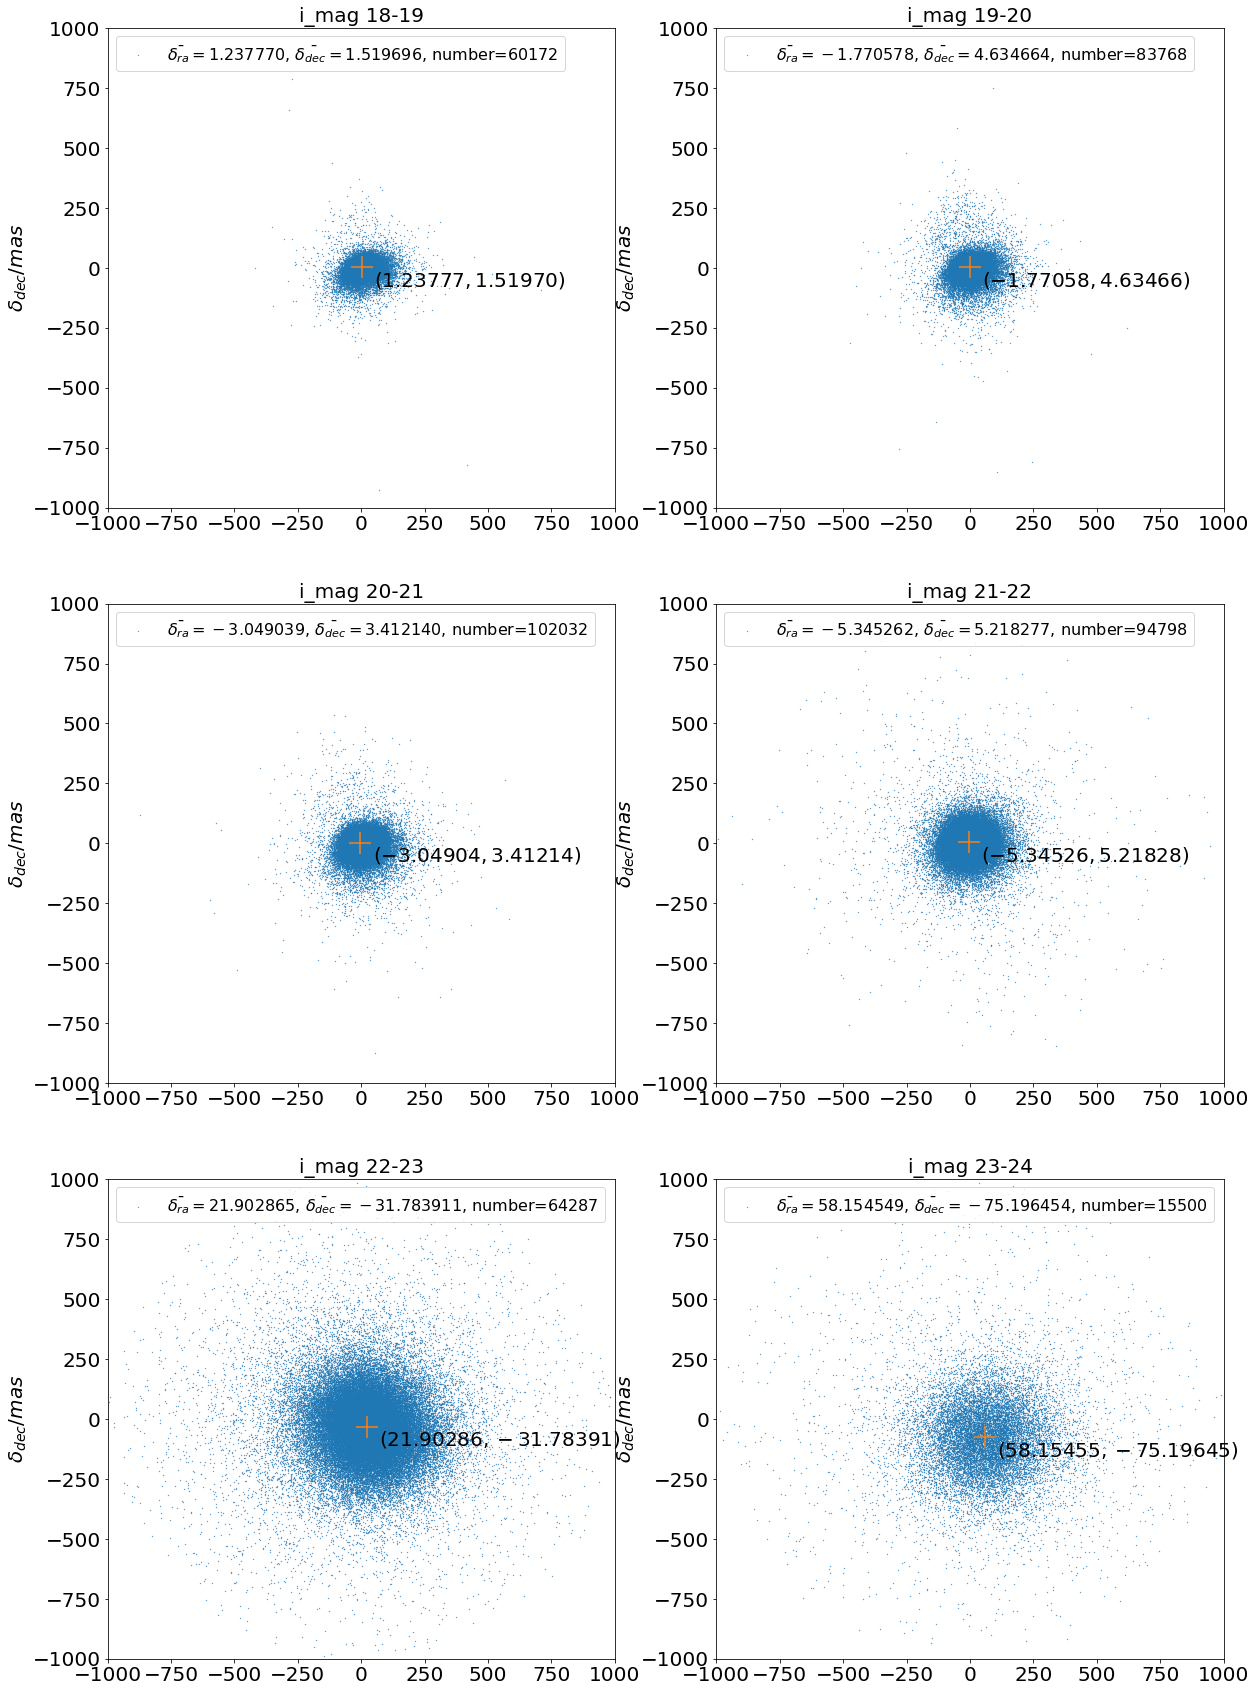

In [87]:
plt.figure(figsize=(20,30))
for i in range(6):
    plt.subplot(321+i)
    plt.title(r'i_mag '+str(18+i)+'-'+str(19+i))
    plt.scatter(delta_ra[i],delta_dec[i],alpha=1,s=0.1,label=r'$\bar{\delta_{ra}}=%f$, $\bar{\delta_{dec}}=%f$, number=%.0f'%(mram[i],mdecm[i],len(mm[i])))
    plt.scatter(mram[i],mdecm[i],s=500,marker='+')
    plt.text(mram[i]+50,mdecm[i]-80,'$(%0.5f,%0.5f)$'%(mram[i],mdecm[i]))
    plt.ylabel(r'$\delta_{dec}/mas$')
    plt.legend(loc=2,fontsize=16)
    plt.axis([-1000,1000,-1000,1000])
plt.savefig('HSC_SDSS-PS_star_mag_dist.png')

'/Users/tianqiu/Downloads/PanStarrs'